# BoolQ Evaluation
This notebook pulls a model via Ollama and evaluates it on the BoolQ dataset

In [1]:
# Install required packages
!pip install datasets requests tqdm pandas scikit-learn psutil
!apt install lshw
!curl -fsSL https://ollama.com/install.sh | sh

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 95.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.2.0
    Uninstalling fsspec-2025.2.0:
      Successfully uninstalled fsspec-2025.2.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.17
    Uninstalling multiprocess-0.70.17:
      Successfully uninstalled multiprocess-0.70.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [2]:
import os
import threading
import json
import time
import psutil
import requests
import subprocess
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Set up ollama server
os.environ['OLLAMA_NUM_PARALLEL'] = '16'
os.environ['OLLAMA_FLASH_ATTENTION'] = '1'

def is_server_running():
    try:
        requests.get('http://localhost:11434/api/tags')
        return True
    except requests.exceptions.ConnectionError:
        return False

def wait_for_server(timeout=30):
    start_time = time.time()
    while time.time() - start_time < timeout:
        if is_server_running():
            return True
        time.sleep(1)
    return False

# Start server if not already running
if not is_server_running():
    server = threading.Thread(
        target=lambda: subprocess.run(['ollama', 'serve'], check=True),
        daemon=True
    )
    server.start()

    if not wait_for_server():
        raise RuntimeError("Ollama server failed to start within timeout")
else:
    print("Ollama server is already running")

2025/02/19 18:45:21 routes.go:1186: INFO server config env="map[HTTPS_PROXY: HTTP_PROXY: NO_PROXY: OLLAMA_DEBUG:false OLLAMA_FLASH_ATTENTION:true OLLAMA_GPU_OVERHEAD:0 OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_KEEP_ALIVE:5m0s OLLAMA_KV_CACHE_TYPE: OLLAMA_LLM_LIBRARY: OLLAMA_LOAD_TIMEOUT:5m0s OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/Users/khushi.malik/.ollama/models OLLAMA_MULTIUSER_CACHE:false OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:16 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* file://* tauri://* vscode-webview://*] OLLAMA_SCHED_SPREAD:false http_proxy: https_proxy: no_proxy:]"
time=2025-02-19T18:45:21.640-05:00 level=INFO source=images.go:432 msg="total blobs: 48"
time=2025-02-19T18:45:21.641-05:00 level=INFO source=images.go:439 msg="total unused 

[GIN] 2025/02/19 - 18:45:22 | 200 |    4.905375ms |       127.0.0.1 | GET      "/api/tags"


In [4]:
# Pull model using Ollama
!ollama pull smollm2:135m

[GIN] 2025/02/19 - 18:45:22 | 200 |      623.75µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling f535f83ec568...   0% ▕                ▏    0 B/270 MB                  

time=2025-02-19T18:45:23.420-05:00 level=INFO source=download.go:176 msg="downloading f535f83ec568 in 3 100 MB part(s)"


pulling manifest 
pulling f535f83ec568...   0% ▕                ▏    0 B/270 MB                  pulling manifest 
pulling f535f83ec568...   0% ▕                ▏    0 B/270 MB                  pulling manifest 
pulling f535f83ec568...   0% ▕                ▏    0 B/270 MB                  pulling manifest 
pulling f535f83ec568...   0% ▕                ▏    0 B/270 MB                  pulling manifest 
pulling f535f83ec568...   1% ▕                ▏ 1.5 MB/270 MB                  pulling manifest 
pulling f535f83ec568...   4% ▕                ▏  11 MB/270 MB                  pulling manifest 
pulling f535f83ec568...   6% ▕█               ▏  17 MB/270 MB                  pulling manifest 
pulling f535f83ec568...   9% ▕█               ▏  24 MB/270 MB                  pulling manifest 
pulling f535f83ec568...  15% ▕██              ▏  39 MB/270 MB                  pulling manifest 
pulling f535f83ec568...  17% ▕██              ▏  45 MB/270 MB                  pulling manifest 
pulling f535

time=2025-02-19T18:45:28.906-05:00 level=INFO source=download.go:176 msg="downloading fbacade46b4d in 1 68 B part(s)"


pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d...   0% ▕                ▏    0 B/  68 B                  pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46

time=2025-02-19T18:45:30.156-05:00 level=INFO source=download.go:176 msg="downloading d502d55c1d60 in 1 675 B part(s)"


pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  675 B                         pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  675 B                         pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  675 B                         pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  67

time=2025-02-19T18:45:31.371-05:00 level=INFO source=download.go:176 msg="downloading 58d1e17ffe51 in 1 11 KB part(s)"


pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  675 B                         
pulling 58d1e17ffe51...   0% ▕                ▏    0 B/ 11 KB                  pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  675 B                         
pulling 58d1e17ffe51... 100% ▕████████████████▏  11 KB                         pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  675 B                         
pulling 58d1e17ffe51... 100% ▕████████████████▏  11 KB              

time=2025-02-19T18:45:32.582-05:00 level=INFO source=download.go:176 msg="downloading b0f58c4c1a3c in 1 561 B part(s)"


pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  675 B                         
pulling 58d1e17ffe51... 100% ▕████████████████▏  11 KB                         
pulling f02dd72bb242... 100% ▕████████████████▏   59 B                         
pulling b0f58c4c1a3c...   0% ▕                ▏    0 B/ 561 B                  pulling manifest 
pulling f535f83ec568... 100% ▕████████████████▏ 270 MB                         
pulling fbacade46b4d... 100% ▕████████████████▏   68 B                         
pulling d502d55c1d60... 100% ▕████████████████▏  675 B                         
pulling 58d1e17ffe51... 100% ▕████████████████▏  11 KB                         
pulling f02dd72bb242... 100% ▕████████████████▏   59 B                         
pulling b0f58c4c1a3c... 100% ▕████████████████▏  561 B                         pullin

In [5]:
def query_ollama(prompt, model):
    """
    Send a query to the Ollama API and get the response
    """
    try:
        response = requests.post('http://localhost:11434/api/generate',
                               json={
                                   'model': model,
                                   'prompt': prompt,
                                   'stream': False
                               })
        response.raise_for_status()
        return response.json()['response']
    except Exception as e:
        raise RuntimeError(f"Error querying Ollama: {e}")

def format_prompt(question, passage):
    """
    Format the prompt for the model
    """
    return f"""Given the following passage and question, answer with only 'yes' or 'no'.

Passage: {passage}

Question: {question}

Answer:"""

def clean_response(response):
    """
    Clean the model's response to get just yes/no
    """
    response = response.lower().strip()
    if 'yes' in response:
        return 'yes'
    elif 'no' in response:
        return 'no'
    else:
        return 'invalid'

In [6]:
# Load BoolQ dataset
print("Loading BoolQ dataset...")
dataset = load_dataset("boolq", split="validation")
print(f"Loaded {len(dataset)} examples")

Loading BoolQ dataset...


README.md:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Loaded 3270 examples


In [7]:
# Evaluate model
print("Starting evaluation...")
results = []
predictions = []
ground_truth = []

# FIXED HERE: was range(range(len(dataset))) before
# gave an error for me, idk how/why it ran and gave outputs earlier
for idx in range(len(dataset)):
    example = dataset[idx]

    # Format prompt
    prompt = format_prompt(example['question'], example['passage'])

    # Get model response
    response = query_ollama(prompt, "smollm2:135m")
    cleaned_response = clean_response(response)

    # Store results
    results.append({
        'question': example['question'],
        'passage': example['passage'],
        'predicted': cleaned_response,
        'actual': 'yes' if example['answer'] else 'no',
        'correct': (cleaned_response == 'yes') == example['answer']
    })

    predictions.append(cleaned_response == 'yes')
    ground_truth.append(example['answer'])

Starting evaluation...


time=2025-02-19T18:45:38.878-05:00 level=INFO source=sched.go:714 msg="new model will fit in available VRAM in single GPU, loading" model=/Users/khushi.malik/.ollama/models/blobs/sha256-f535f83ec568d040f88ddc04a199fa6da90923bbb41d4dcaed02caa924d6ef57 gpu=0 parallel=16 available=5726633984 required="2.1 GiB"
time=2025-02-19T18:45:38.879-05:00 level=INFO source=server.go:100 msg="system memory" total="8.0 GiB" free="1.5 GiB" free_swap="0 B"
time=2025-02-19T18:45:38.880-05:00 level=INFO source=memory.go:356 msg="offload to metal" layers.requested=-1 layers.model=31 layers.offload=31 layers.split="" memory.available="[5.3 GiB]" memory.gpu_overhead="0 B" memory.required.full="2.1 GiB" memory.required.partial="2.1 GiB" memory.required.kv="720.0 MiB" memory.required.allocations="[2.1 GiB]" memory.weights.total="922.6 MiB" memory.weights.repeating="868.6 MiB" memory.weights.nonrepeating="54.0 MiB" memory.graph.full="644.5 MiB" memory.graph.partial="644.5 MiB"
time=2025-02-19T18:45:38.880-05:00

[GIN] 2025/02/19 - 18:45:40 | 200 |  1.462220333s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:43 | 200 |  2.978140958s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:43 | 200 |  543.116917ms |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:44 | 200 |  679.034458ms |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:44 | 200 |    65.09625ms |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:44 | 200 |    52.68675ms |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:44 | 200 |    62.18575ms |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:46 | 200 |  1.286199333s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:46 | 200 |      44.034ms |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:46 | 200 |  640.694417ms |       127.0.0.1 | POST     "/api/generate"
[GIN] 2025/02/19 - 18:45:46 | 200 |   71.985667ms 

In [8]:
# Calculate metrics
accuracy = accuracy_score(ground_truth, predictions)
print(f"\nAccuracy: {accuracy:.4f}")

# Create detailed report
results_df = pd.DataFrame(results)
print("\nClassification Report:")
print(classification_report(ground_truth, predictions))

# Save results
results_df.to_csv('llama3_boolq_results.csv', index=False)
print("\nResults saved to llama3_boolq_results.csv")


Accuracy: 0.5798

Classification Report:
              precision    recall  f1-score   support

       False       0.40      0.23      0.29      1237
        True       0.63      0.79      0.70      2033

    accuracy                           0.58      3270
   macro avg       0.52      0.51      0.50      3270
weighted avg       0.54      0.58      0.55      3270


Results saved to llama3_boolq_results.csv


In [9]:
# Error Analysis
print("\nError Analysis:")
errors_df = results_df[~results_df['correct']]
print(f"\nTotal errors: {len(errors_df)}")

# Show some example errors
print("\nExample errors:")
for _, row in errors_df.head(5).iterrows():
    print(f"\nQuestion: {row['question']}")
    print(f"Passage excerpt: {row['passage'][:200]}...")
    print(f"Predicted: {row['predicted']}")
    print(f"Actual: {row['actual']}")
    print("-" * 80)


Error Analysis:

Total errors: 1374

Example errors:

Question: does ethanol take more energy make that produces
Passage excerpt: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total a...
Predicted: yes
Actual: no
--------------------------------------------------------------------------------

Question: is barq's root beer a pepsi product
Passage excerpt: Barq's /ˈbɑːrks/ is an American soft drink. Its brand of root beer is notable for having caffeine. Barq's, created by Edward Barq and bottled since the turn of the 20th century, is owned by the Barq f...
Predicted: yes
Actual: no
--------------------------------------------------------------------------------

Question: is it bad to wash your hair with shower gel
Passage excerpt: Shower gels for men may contain the ingredient menthol, which gives a cooling and stimulating sensation on the 

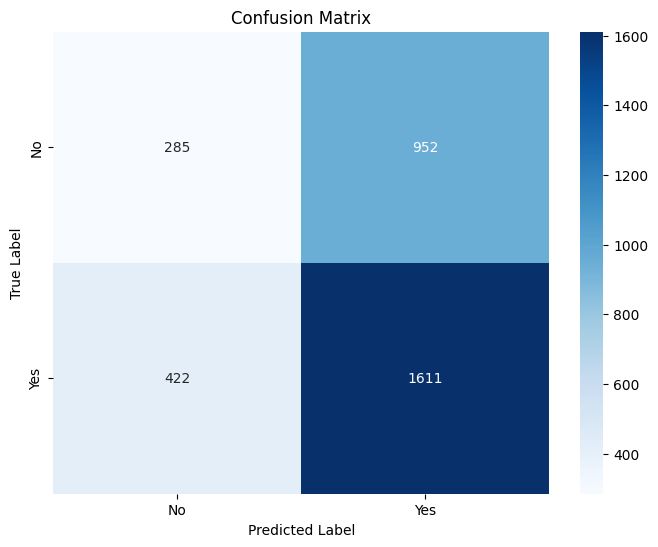

In [10]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()